# Customer Clustering - K means & PCA

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-clustering/segmentation data.csv
/kaggle/input/customer-clustering/segmentation data legend.xlsx


# 1. Reading and understanding the data

In [2]:
customers = pd.read_csv("../input/customer-clustering/segmentation data.csv")

In [3]:
customers.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [5]:
customers.describe()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,1.000010e+08,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,5.774946e+02,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,1.000000e+08,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,1.000005e+08,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,1.000010e+08,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000015e+08,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000020e+08,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


**We do not need ID**

In [6]:
customers = customers.drop(['ID'], axis = 1)

In [7]:
customers.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,67,2,124670,1,2
1,1,1,22,1,150773,1,2
2,0,0,49,1,89210,0,0
3,0,0,45,1,171565,1,1
4,0,0,53,1,149031,1,1


# 1. EDA

<AxesSubplot:>

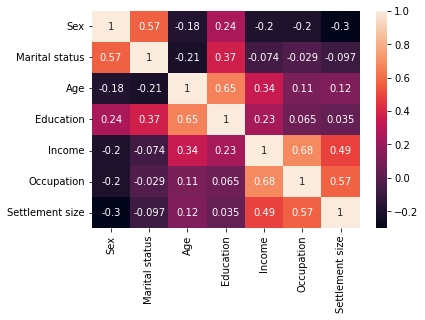

In [8]:
corrs = customers.corr()
sns.heatmap(corrs, annot=True)

**Lets look at the distributions of our numeric variables**

<AxesSubplot:xlabel='Income', ylabel='Count'>

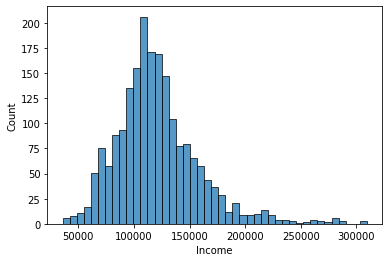

In [9]:
sns.histplot(data=customers,x=customers.Income)

<AxesSubplot:xlabel='Age', ylabel='Count'>

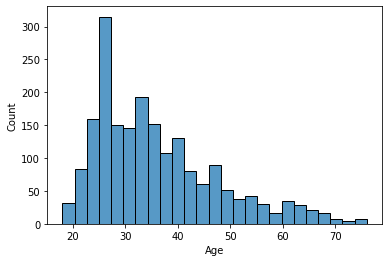

In [10]:
sns.histplot(data=customers,x=customers.Age)

**Note: Both of these look like they could be log transformed**

**Now looking at our categorical variables!**

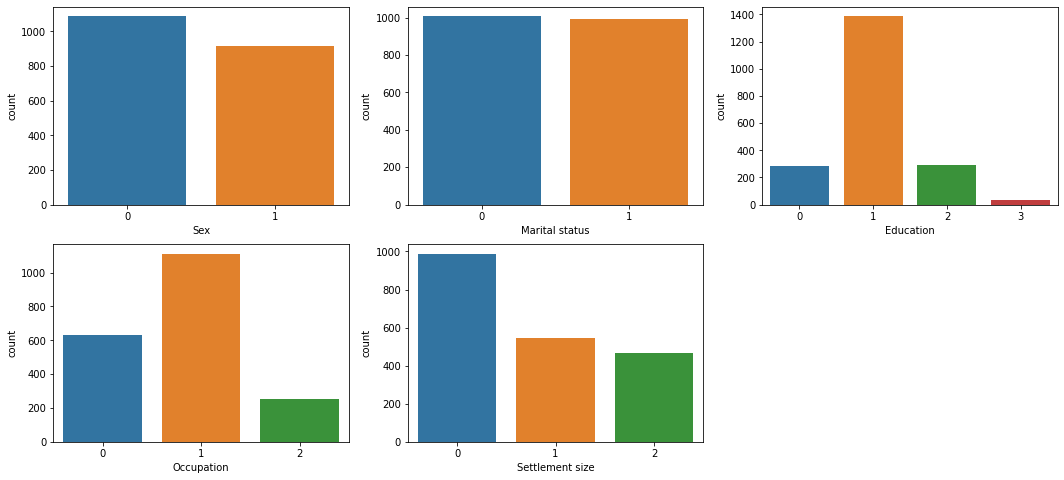

In [11]:
plt.figure(figsize=(18,8),num=1)
m=1
for i in customers.drop(['Age','Income'],axis=1).columns:
    plt.subplot(2,3,m)
    sns.countplot(x=i,data=customers)
    m+=1

Going to have some fun with plots

<AxesSubplot:xlabel='Income', ylabel='Age'>

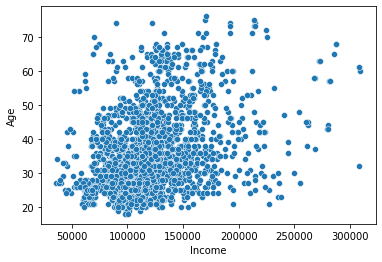

In [12]:
sns.scatterplot(x=customers.Income,y=customers.Age)

<AxesSubplot:xlabel='Education', ylabel='Income'>

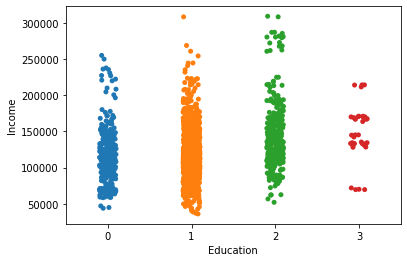

In [13]:
sns.stripplot(x=customers.Education, y=customers.Income)

<AxesSubplot:xlabel='Occupation', ylabel='Income'>

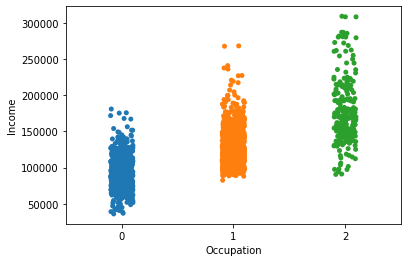

In [14]:
sns.stripplot(x=customers.Occupation, y=customers.Income)

<AxesSubplot:xlabel='Settlement size', ylabel='Income'>

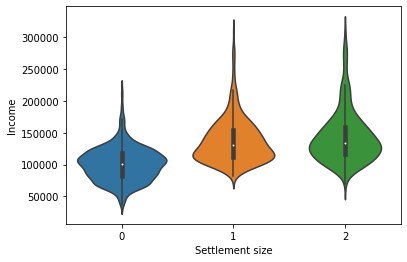

In [15]:
sns.violinplot(x=customers["Settlement size"], y=customers.Income)

<AxesSubplot:xlabel='Occupation', ylabel='Age'>

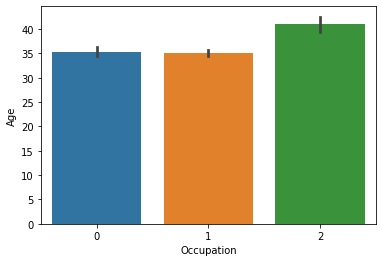

In [16]:
sns.barplot(x=customers.Occupation, y=customers.Age)

**Are there any outliers in the income variable?**

<AxesSubplot:xlabel='Income'>

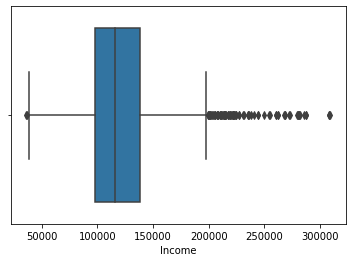

In [17]:
sns.boxplot(x=customers.Income)

**Visualizing the gender pay-gap with a bivariate kde plot and a scatter plot**

<AxesSubplot:xlabel='Age', ylabel='Income'>

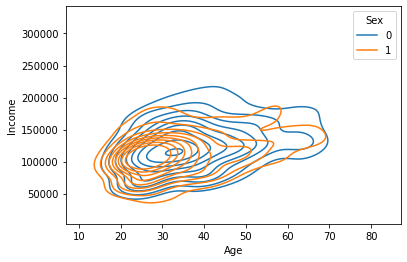

In [18]:
sns.kdeplot(
    data=customers,
    x="Age",
    y="Income",
    hue="Sex",
    thresh=.1,
)

<AxesSubplot:xlabel='Age', ylabel='Income'>

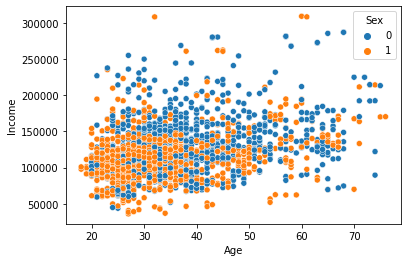

In [19]:
sns.scatterplot(
     data=customers,
    x="Age",
    y="Income",
    hue="Sex",
)

**What percentage of women are married compared to men?**

In [20]:
married = customers.groupby(['Sex','Marital status']).Age.count()
married
#0 is Male
#1 is Female

Sex  Marital status
0    0                 829
     1                 257
1    0                 178
     1                 736
Name: Age, dtype: int64

In [21]:
percentage_of_men = 257 / (customers[customers.Sex == 0].Sex.count()) * 100
print("Percentage of men married: " + str(percentage_of_men.round(1)) + "%")

percentage_of_women = 736 / (customers[customers.Sex == 1].Sex.count()) * 100
print("Percentage of women married: " + str(percentage_of_women.round(1)) + "%")


Percentage of men married: 23.7%
Percentage of women married: 80.5%


**Lets look at clustering now - For the purpose of this cluster I would like to easiy visualise the clustering groups so I will only be clustering on two variables; age and income.**

In [22]:
data=customers[['Age','Income']]
data.head()

,Age,Income
0,67,124670
1,22,150773
2,49,89210
3,45,171565
4,53,149031


**We are going to standardize these two numeric variables since standardization prevents variables with larger scales from dominating how clusters are defined.**

<AxesSubplot:xlabel='Income', ylabel='Density'>

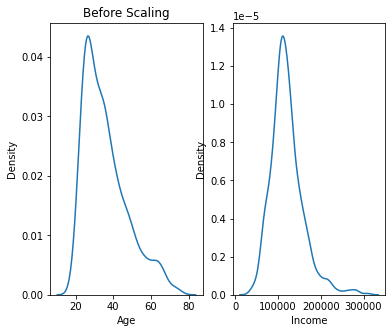

In [23]:
#lets tranaform these variables by standardizing them.

#before standardizing
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(6, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(data['Age'], ax=ax1)
sns.kdeplot(data['Income'], ax=ax2)

In [24]:
#transforming
col_names = data.columns
features = data[col_names]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled = pd.DataFrame(features, columns = col_names)
scaled.head()


,Age,Income
0,2.653614,0.097524
1,-1.187132,0.782654
2,1.117316,-0.833202
3,0.775916,1.328386
4,1.458716,0.736932


<AxesSubplot:xlabel='Income', ylabel='Density'>

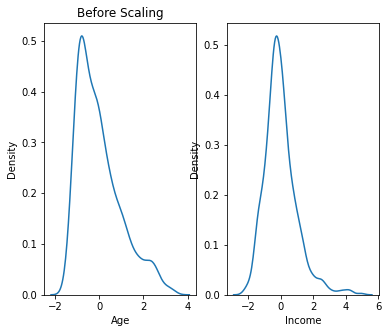

In [25]:
#after transforming
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(6, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(scaled['Age'], ax=ax1)
sns.kdeplot(scaled['Income'], ax=ax2)

# 1. CLUSTERING WITH K-Means

In [26]:
from sklearn.cluster import KMeans

**Using elbow method to test for best clusters**

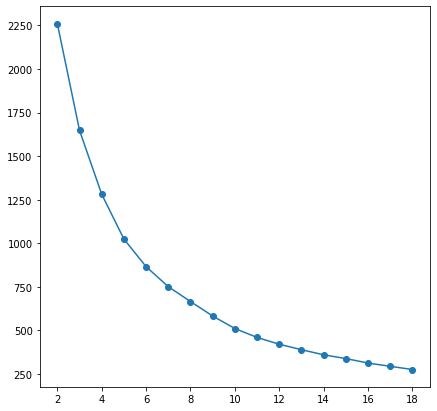

In [27]:
clusters_range=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
inertias=[]

for c in clusters_range:
    kmeans=KMeans(n_clusters=c, random_state=0).fit(scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(7,7))
plt.plot(clusters_range,inertias, marker='o')

**looks like around 5/6 clusters will be the best**

In [28]:
#Using 5 clusters
kmeans=KMeans(n_clusters=5,random_state=0) 
kmeans.fit(scaled)

KMeans(n_clusters=5, random_state=0)

In [29]:
prediction=kmeans.fit_predict(scaled)
prediction

array([0, 2, 3, ..., 1, 1, 1], dtype=int32)

In [30]:
clustered_data = data.copy()
clustered_data["cluster_index"] = prediction

<AxesSubplot:xlabel='Age', ylabel='Income'>

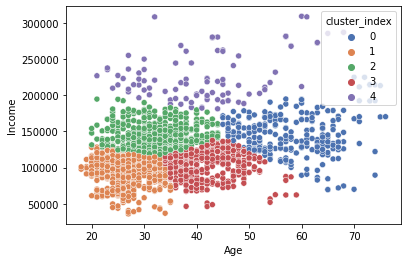

In [31]:
#lets visualise the clusters
sns.scatterplot(x=clustered_data.Age,
                y=clustered_data.Income,
                hue=clustered_data.cluster_index,
                palette="deep")

# 1. INTERPRETATION

In [32]:
for i in range(5):
    average_age = clustered_data[clustered_data.cluster_index == i].Age.mean()
    average_income = clustered_data[clustered_data.cluster_index == i].Income.mean()
    average_age = round(average_age,0)
    average_income = round(average_income,0)
    print("The average age for cluster {} is {}. The average income is {}.".format(i, average_age, average_income))

The average age for cluster 0 is 58.0. The average income is 144711.0.
The average age for cluster 1 is 26.0. The average income is 94646.0.
The average age for cluster 2 is 32.0. The average income is 142238.0.
The average age for cluster 3 is 42.0. The average income is 102870.0.
The average age for cluster 4 is 42.0. The average income is 226504.0.


In [33]:
clustered_data.cluster_index.value_counts()

1    721
2    501
3    427
0    257
4     94
Name: cluster_index, dtype: int64

# 1. PCA with K-Means

**We are going to go go back to using our original customers dataset amnd keep all the variables, we will use Principal Component Analysis to reduce the number of dimensions**

**We will still standardize our numeric variables**

In [34]:
customers.head()
customers[['Age', 'Income']] = StandardScaler().fit_transform(customers[['Age', 'Income']])

In [35]:
customers.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,2.653614,2,0.097524,1,2
1,1,1,-1.187132,1,0.782654,1,2
2,0,0,1.117316,1,-0.833202,0,0
3,0,0,0.775916,1,1.328386,1,1
4,0,0,1.458716,1,0.736932,1,1


In [36]:
from sklearn.decomposition import PCA

#define PCA model to use
#7 Variables
pca = PCA(n_components=7)

#fit PCA model to data
pca_fit = pca.fit(customers)

**Creating a scree plot to see how many components we should be using, scree plots allow us to see how much each principal components represents of the original data set.**

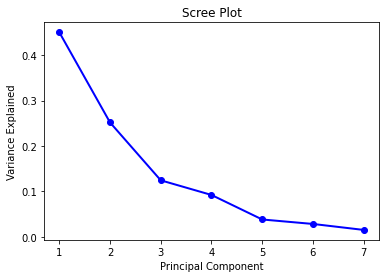

In [37]:
#creating scree plot - taken from statology.com

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [38]:
print(pca.explained_variance_ratio_)

[0.45071403 0.2518607  0.12431802 0.09203774 0.03798222 0.02811108
 0.01497622]


**We are going to use 4 pricipal components - with a a variance threshold of 80% , chosing 4 allows us to have 82%**

In [39]:
pc = pca.fit_transform(customers)
pca_customers = pd.DataFrame(data = pc, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6','PC 7'])
pca_customers

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7
0,2.209938,1.676779,-1.039575,1.120095,-0.104221,-0.127451,0.013007
1,0.379699,-1.597321,0.819046,0.668274,0.591856,-0.157374,0.097852
2,-0.476246,1.522160,-0.980652,-0.249745,0.084197,0.094301,-0.136540
3,1.499771,-0.003517,-0.407090,-0.645262,0.307986,0.034804,-0.003673
4,1.448050,0.650585,-0.738235,-0.303381,0.028634,-0.111086,-0.247901
...,...,...,...,...,...,...,...
1995,-0.078225,1.233563,-0.150006,-0.609559,0.543284,-0.653883,-0.043469
1996,-0.755167,-0.267327,0.923829,-0.371482,-0.277219,-0.068317,-0.048999
1997,-1.492273,0.043916,-1.024831,-0.569949,0.225423,0.036137,-0.279110
1998,-1.555343,-0.008454,0.731697,-0.099638,0.424165,0.068686,0.029552


In [40]:
#Choosing the first 4 Principal Components
pca_customers = pca_customers[['PC 1', 'PC 2','PC 3','PC 4']]

**Yet again we are going to look at how many clusters we should have using the elbow method**

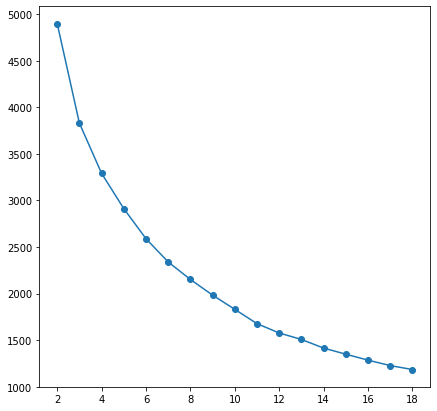

In [41]:
clusters_range=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
inertias=[]

for c in clusters_range:
    kmeans=KMeans(n_clusters=c, random_state=0).fit(pca_customers)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(7,7))
plt.plot(clusters_range,inertias, marker='o')

**Going to use 5 clusters again.**

In [42]:
kmeans=KMeans(n_clusters=5,random_state=0)
kmeans.fit(pca_customers)

KMeans(n_clusters=5, random_state=0)

In [43]:
prediction_pca = kmeans.fit_predict(pca_customers)
prediction_pca

array([0, 1, 3, ..., 2, 2, 2], dtype=int32)

In [44]:
clustered_data_pca = pca_customers.copy()
clustered_data_pca["cluster_index"] = prediction_pca
clustered_data_pca

,PC 1,PC 2,PC 3,PC 4,cluster_index
0,2.209938,1.676779,-1.039575,1.120095,0
1,0.379699,-1.597321,0.819046,0.668274,1
2,-0.476246,1.522160,-0.980652,-0.249745,3
3,1.499771,-0.003517,-0.407090,-0.645262,4
4,1.448050,0.650585,-0.738235,-0.303381,0
...,...,...,...,...,...
1995,-0.078225,1.233563,-0.150006,-0.609559,3
1996,-0.755167,-0.267327,0.923829,-0.371482,2
1997,-1.492273,0.043916,-1.024831,-0.569949,2
1998,-1.555343,-0.008454,0.731697,-0.099638,2


**This data cannot be visualised as it is four dimensions - however for the purpose of just viusalising something we will plot with the frist two dimensions.**

<AxesSubplot:xlabel='PC 1', ylabel='PC 2'>

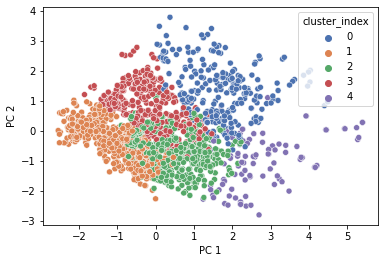

In [45]:
sns.scatterplot(x=clustered_data_pca['PC 1'],
                y=clustered_data_pca['PC 2'],
                hue=clustered_data.cluster_index,
                palette="deep")